In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.simplefilter('ignore')

In [19]:
df = pd.read_csv(r"E:\Data Science by SRK\Machine_learning\Classification\Gene_data\cleaned_dataset_Gene.csv")

In [20]:
df

,Gene_One,Gene_Two,Cancer_Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1
...,...,...,...
2133,5.0,6.5,1
2134,3.4,6.6,0
2135,2.7,6.5,0
2136,3.3,5.6,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene_One        2138 non-null   float64
 1   Gene_Two        2138 non-null   float64
 2   Cancer_Present  2138 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 50.2 KB


In [22]:
df.isnull().sum()

Gene_One          0
Gene_Two          0
Cancer_Present    0
dtype: int64

# X and y

In [23]:
X = df.drop(columns = ['Cancer_Present'])
y = df['Cancer_Present']

# Train_test_split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= True)

# XGBoost

**Applying Hyperparameter tuning for identifying best parameters for xgboost**

In [25]:
# !pip install xgboost


In [26]:
from sklearn.model_selection import GridSearchCV

# modelling

from xgboost import XGBClassifier

estimator_xgb = XGBClassifier()

# parameters grid
param_grid_xgb = {"n_estimators" : [1,5,10,20],
                  'max_depth': [3,4,5],
                'gamma' : [0.1, 0.15, 0.3, 0.5, 1]}

# grid search
grid_xgb = GridSearchCV(estimator_xgb, param_grid_xgb, cv = 5, scoring = 'accuracy')
grid_xgb.fit(X_train, y_train)

# best parameters for GradientBoostingClassifier model
grid_xgb.best_params_

{'gamma': 1, 'max_depth': 4, 'n_estimators': 20}

# XGB Model imortant features

In [27]:
feats_xgb = pd.DataFrame(data=grid_xgb.best_estimator_.feature_importances_,
                        index = X.columns,
                        columns=['Importance'])
imp_features_list_xgb = feats_xgb[feats_xgb['Importance'] > 0].index.to_list()
imp_features_list_xgb

['Gene_One', 'Gene_Two']

# Xtreme GradientBoost with important features and best hyperparameters

In [31]:
X_imp_xgb = X[imp_features_list_xgb]

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_imp_xgb, y, test_size = 0.2,
                                                                   random_state = True)

# modelling
from xgboost import XGBClassifier
xgb = XGBClassifier(gamma = 1, max_depth = 4, n_estimators = 20)
xgb.fit(X_train_xgb, y_train_xgb)

#Evaluation train data
from sklearn.metrics import accuracy_score
ypred_train = xgb.predict(X_train_xgb)
print("Train accuracy : ", accuracy_score(y_train_xgb, ypred_train))

# Cross_val_score
from sklearn.model_selection import cross_val_score

print("cross_val_score : ", cross_val_score(xgb, X_train_xgb, y_train_xgb, cv = 5).mean())

#Evaluation test data
ypred_test = xgb.predict(X_test_xgb)
print("Test accuracy : ", accuracy_score(y_test_xgb, ypred_test))


Train accuracy :  0.9222222222222223
cross_val_score :  0.9146198830409358
Test accuracy :  0.9205607476635514


In [30]:
%%timeit
xgb.fit(X_train_xgb, y_train_xgb)


21.9 ms ± 484 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Final model

In [32]:
xgb = XGBClassifier(gamma = 1, max_depth = 4, n_estimators = 20)


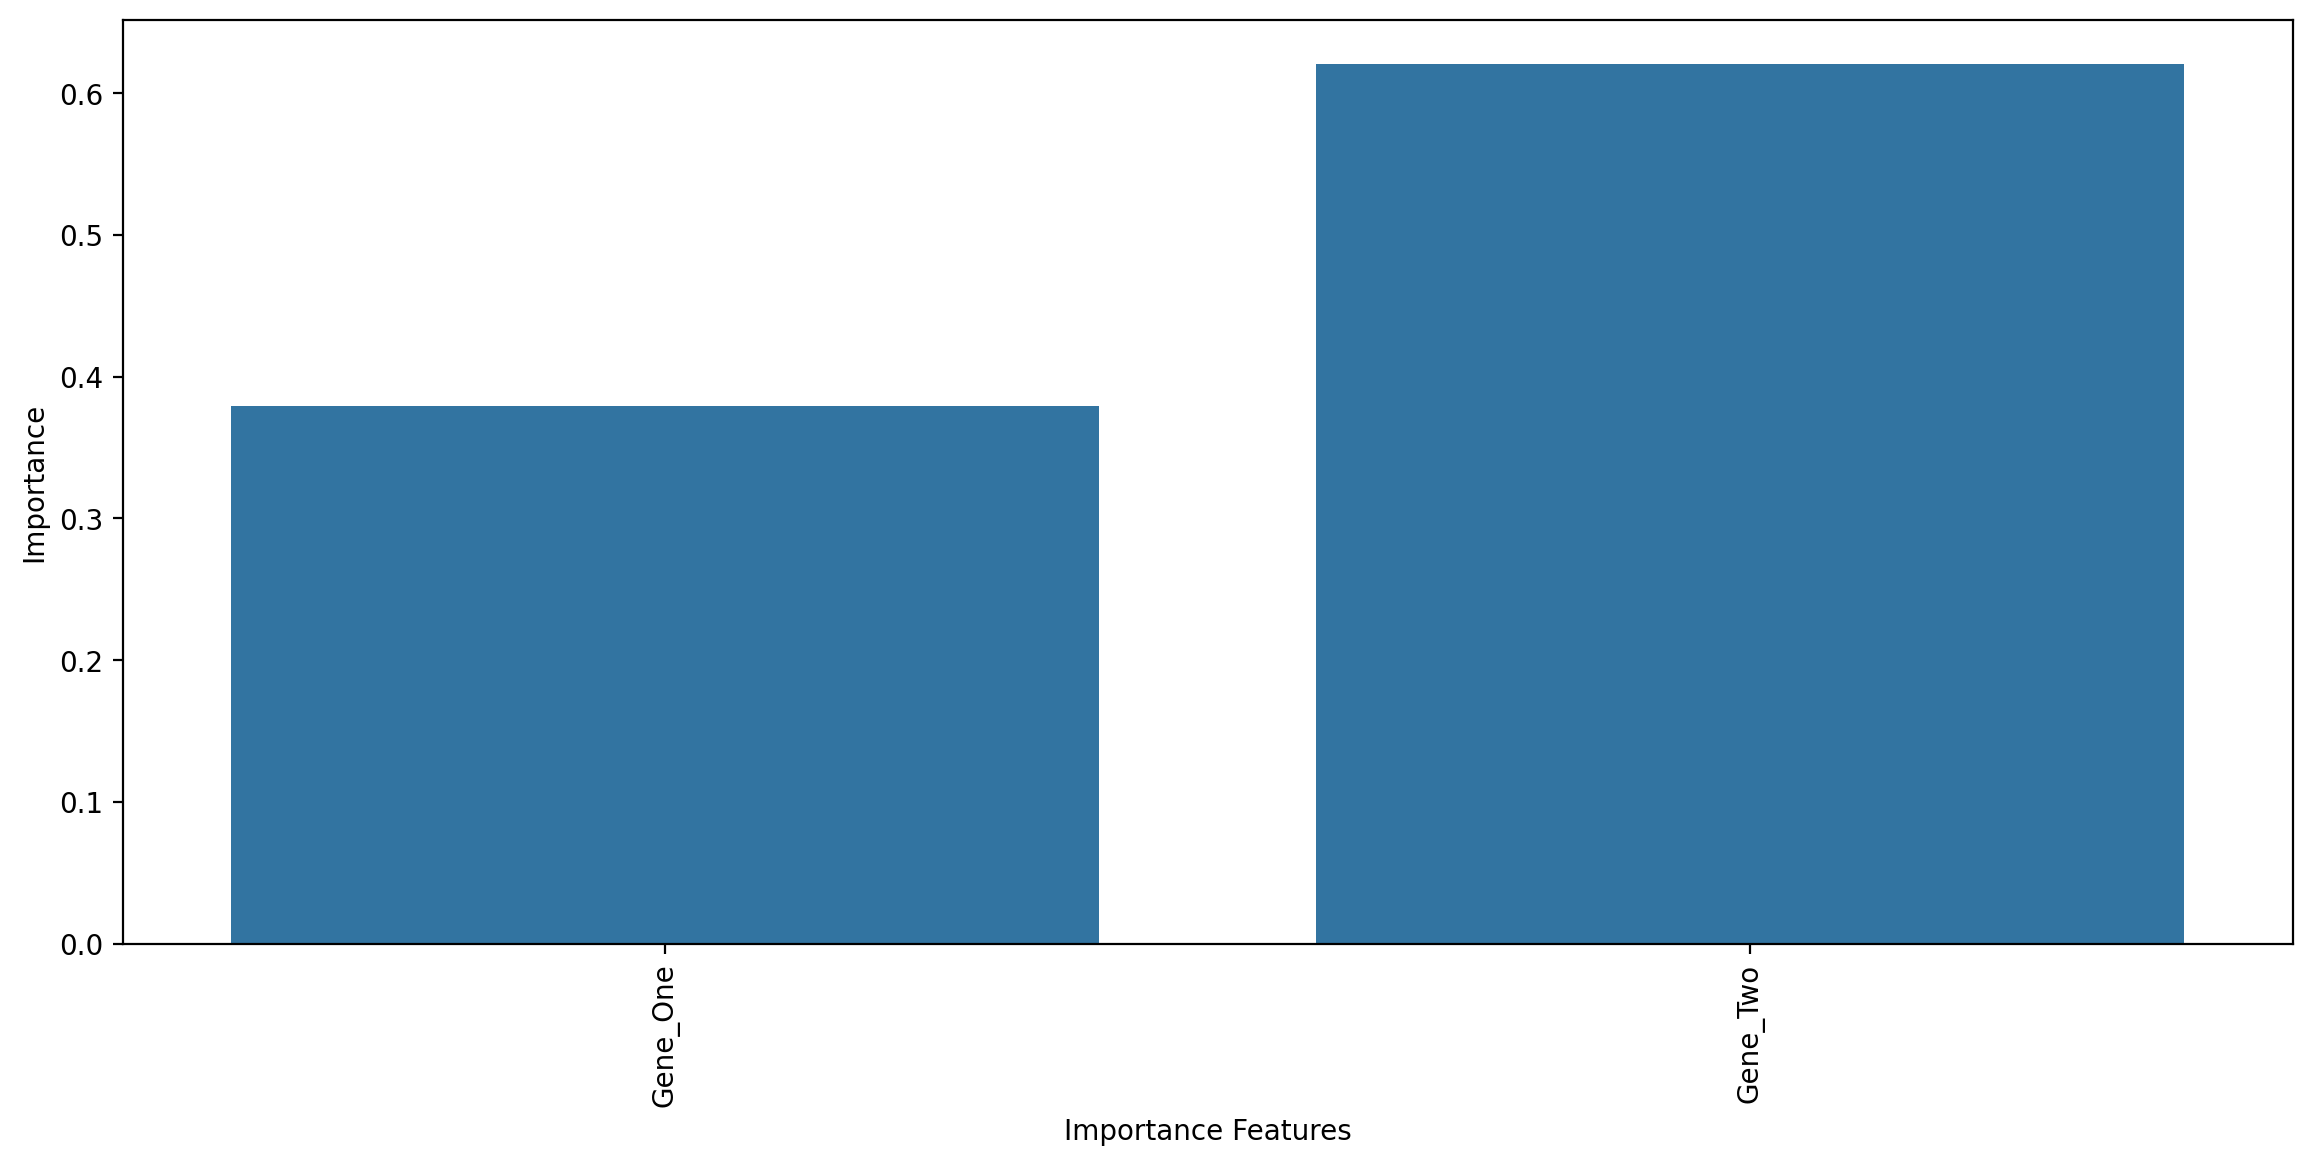

In [33]:
plt.figure(figsize = (14,6), dpi = 200)

sns.barplot(data = feats_xgb[feats_xgb['Importance'] > 0].sort_values('Importance'),
           x = feats_xgb[feats_xgb['Importance'] > 0].index,
           y = 'Importance')
plt.xticks(rotation = 90)
plt.xlabel('Importance Features')
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_xgb, ypred_test)

array([[193,  23],
       [ 11, 201]], dtype=int64)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb, ypred_test))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       216
           1       0.90      0.95      0.92       212

    accuracy                           0.92       428
   macro avg       0.92      0.92      0.92       428
weighted avg       0.92      0.92      0.92       428

